## Import

In [15]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import re,json
user='phong@bsides.edmonton'


## Suspicious Signin Graph -> Initial Access

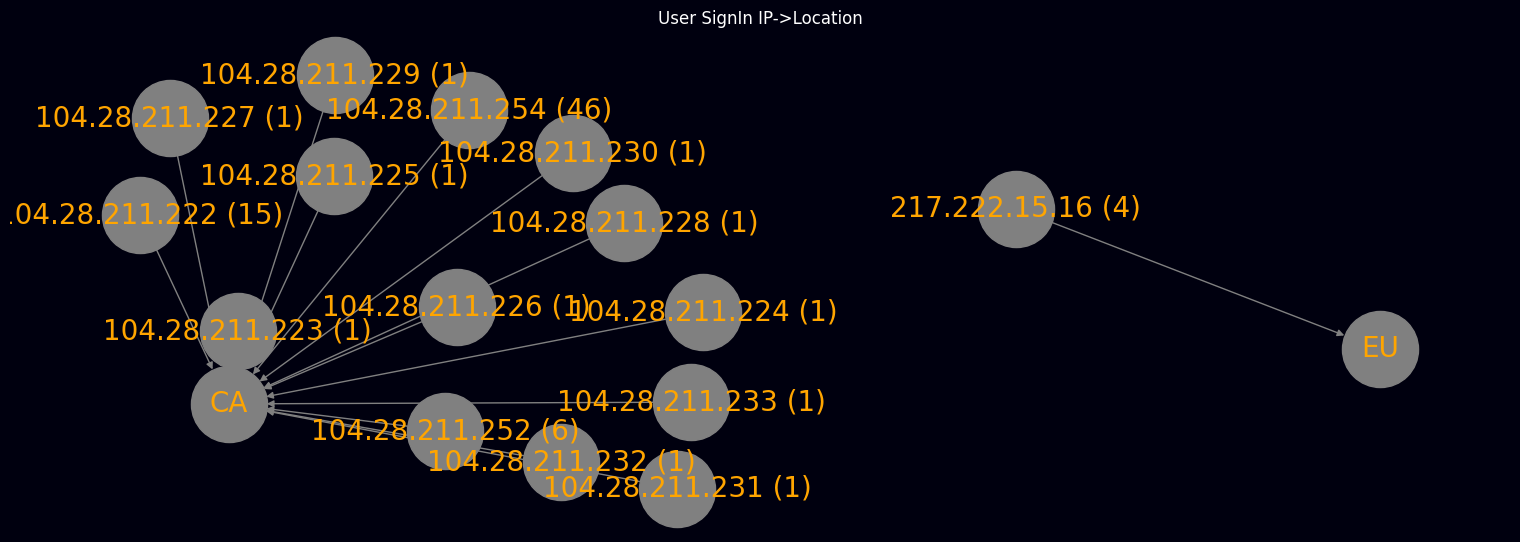

In [177]:
signinlog_path = 'SignIn.csv'
df = pd.read_csv(signinlog_path)
df_signin = df[df['UserPrincipalName'] == user]
features = ['IPAddress', 'Location']
# dropNA
df_signin_clean = df_signin[features].dropna()
ip_count = df_signin_clean['IPAddress'].value_counts()
#Create grahp
G = nx.DiGraph()
# Add nodes and edges
for _, row in df_signin_clean.iterrows():
    ip = row['IPAddress']
    location = row['Location']
    G.add_node(ip, type='IPAddress')
    G.add_node(location, type='Location')
    G.add_edge(ip, location)
# Create labels
labels = {}
for node in G.nodes():
    if node in ip_count:
        labels[node] = f"{node} ({ip_count[node]})" #show IP and Count
    else:
        labels[node] = node # ONly Location
fig=plt.figure(figsize=(15, 5))
pos = nx.spring_layout(G,k=0.8)  # pos nodes
nx.draw(G, pos, with_labels=False, node_size=3000, node_color="grey", font_size=5, font_weight="bold", edge_color='gray')
# Draw labels for both IPs and locations
nx.draw_networkx_labels(G, pos, labels=labels, font_size=20,font_color='orange')
fig.set_facecolor("#00000F")
plt.title('User SignIn IP->Location')
plt.show()


#### Suspicious Signin Dive Deeper

In [178]:
df_sus=df_signin[df_signin['IPAddress'] == '217.222.15.16' ]
selected_col =['TimeGenerated [UTC]','ResultType','CorrelationId','AppDisplayName','ResourceDisplayName','AuthenticationRequirement','RiskDetail','RiskEventTypes','RiskState','UniqueTokenIdentifier']
df_sus[selected_col].sort_values(by='TimeGenerated [UTC]')

,TimeGenerated [UTC],ResultType,CorrelationId,AppDisplayName,ResourceDisplayName,AuthenticationRequirement,RiskDetail,RiskEventTypes,RiskState,UniqueTokenIdentifier
36,"9/13/2024, 7:16:57.980 PM",50074,d7d878ba-3618-4cd2-9088-1fa8db46492a,OfficeHome,Microsoft Graph,multiFactorAuthentication,none,[],atRisk,LIIc7MChTEGgBgKHSKYtAA
37,"9/13/2024, 7:17:10.444 PM",0,d7d878ba-3618-4cd2-9088-1fa8db46492a,OfficeHome,Microsoft Graph,multiFactorAuthentication,userPassedMFADrivenByRiskBasedPolicy,"[""unfamiliarFeatures""]",remediated,LIIc7MChTEGgBgKHSKYtAA
38,"9/13/2024, 7:17:21.107 PM",0,d7d878ba-3618-4cd2-9088-1fa8db46492a,OfficeHome,Microsoft Graph,multiFactorAuthentication,userPassedMFADrivenByRiskBasedPolicy,"[""unfamiliarFeatures""]",remediated,LIIc7MChTEGgBgKHSKYtAA
39,"9/13/2024, 7:18:53.671 PM",0,d7d878ba-3618-4cd2-9088-1fa8db46492a,OfficeHome,Microsoft Graph,multiFactorAuthentication,userPassedMFADrivenByRiskBasedPolicy,"[""unfamiliarFeatures"",""unlikelyTravel""]",remediated,LIIc7MChTEGgBgKHSKYtAA


#### GraphAPI -> Account Discovery T1087, Permission Groups Discovery T1069

In [24]:
df_graph=pd.read_csv('Graph.csv')
binby='30min'
df_graph['TimeGenerated [UTC]'] =pd.to_datetime(df_graph['TimeGenerated [UTC]'], format='%m/%d/%Y, %I:%M:%S.%f %p')

# agg bin 30mins
df_graphbin = df_graph.resample(binby, on='TimeGenerated [UTC]').agg({'ResponseSizeBytes': 'sum'})
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, subplot_titles=("30 Mins bins", "Log scale"))
fig.add_trace(go.Scatter(
    x=df_graphbin.index,
    y=df_graphbin['ResponseSizeBytes'],
    mode='lines+markers',
    name='Response Size Bytes',
    hoverinfo='x+y',
    line=dict(shape='linear'),
    text=df_graphbin['ResponseSizeBytes']
), row=1, col=1)
fig.add_trace(go.Scatter(
    x=df_graphbin.index,
    y=df_graphbin['ResponseSizeBytes'],
    mode='lines+markers+text',
    name='Response Size Bytes',
    hoverinfo='x+y',
    line =dict(shape='linear'),
    text = df_graphbin['ResponseSizeBytes'],
    textposition ='top center',
), row=1, col=2)
fig.update_layout(
    title='GraphAPI 30 mins bin',
    title_x=0.5,
    xaxis_title='Time',
    yaxis_title='Response Size (Bytes)',
    # yaxis_type='log',
    hovermode='x unified',
    xaxis=dict(tickformat='%Y-%m-%d %H:%M'),
    template='plotly_dark' 
)
fig.update_yaxes(type="log", row=1, col=2)
fig.show()

In [265]:
df_graph.groupby('SignInActivityId').agg(
    byte_sum=('ResponseSizeBytes', 'sum'),
    IPAddress_set=('IPAddress', lambda x: set(x))
).sort_values(by='byte_sum',ascending=False)

,byte_sum,IPAddress_set
SignInActivityId,,
LIIc7MChTEGgBgKHSKYtAA,4607166360,{217.222.15.16}
VJRHAgbxXU28U9ciLDNfAA,27952261,{104.28.211.254}
x3mdy6LCMEWpMN0JKjhhAA,27620935,{104.28.211.254}
VLxHxvaEra28U9ciLDNfAA,15165165,{104.28.211.254}
BOcaEldpH0yVjPTGBNRUAA,5533079,{104.28.211.254}
VJRHAgbxXU28U94BEy8fAA,3153650,{104.28.211.254}
YPbIVz9APE2R3V3bxeZVAA,261919,{104.28.211.254}
x3ucC2X4BEy8vuIswUllAA,124603,{104.28.211.222}
N6AsFnl5mkCGZiPGMRtLAA,1596,{104.28.211.222}


In [266]:
SignInID='LIIc7MChTEGgBgKHSKYtAA'
df_graph_sus=df_graph.copy()
df_graph_sus=df_graph_sus[df_graph_sus['SignInActivityId'] == SignInID]
df_graph_sus['requested_service'] = df_graph_sus['RequestUri'].str.extract(r'(https?://[^/]+/[^/]+/[^/?]+)')
df_graph_sus.groupby('requested_service')['ResponseSizeBytes'].sum().reset_index()


,requested_service,ResponseSizeBytes
0,https://graph.microsoft.com/beta/directoryRoles,10934421
1,https://graph.microsoft.com/beta/groups,61611121
2,https://graph.microsoft.com/beta/users,4534620818


#### MFA Reg -> Modify Authentication Process  T1556

In [215]:
file_path = 'audit.csv'
data = pd.read_csv(file_path)
data['TimeGenerated [UTC]'] =pd.to_datetime(data['TimeGenerated [UTC]'], format='%m/%d/%Y, %I:%M:%S.%f %p')

secinfoupdate_data= data.copy()
secinfoupdate_data = secinfoupdate_data[(secinfoupdate_data['TargetResources'].str.contains(user) | secinfoupdate_data['InitiatedBy'].str.contains(user))]
secinfoupdate_data=secinfoupdate_data[(
        secinfoupdate_data['OperationName'].str.contains("security info") &
        secinfoupdate_data['OperationName'].str.contains(r"\b(?:User|Admin)\b") &
        secinfoupdate_data['OperationName'].str.contains(r"\b(?:started|changed|registered|updated|reviewed|deleted)\b")
    )|(
        secinfoupdate_data['OperationName'].str.contains(r"\b(?:Disable Strong Authentication|passwordless phone sign-in credential|Windows Hello for Business credential|FIDO2 security key)\b")
    )]
secinfoupdate_data['IPAddress'] = secinfoupdate_data['InitiatedBy'].apply(lambda x: json.loads(x)['user']['ipAddress'])
secinfoupdate_data[['TimeGenerated [UTC]','IPAddress','OperationName']]

,TimeGenerated [UTC],IPAddress,OperationName
87,2024-09-13 20:08:15.681,217.222.15.16,User registered all required security info
88,2024-09-13 20:08:15.681,217.222.15.16,User registered security info
89,2024-09-13 20:08:15.681,217.222.15.16,User started security info registration


In [164]:
aadaudit_data=data.copy()
aadaudit_data = aadaudit_data[aadaudit_data['OperationName'] == "Update user"]
aadaudit_data = aadaudit_data[(aadaudit_data['TargetResources'].str.contains(user) | aadaudit_data['InitiatedBy'].str.contains(user))]
aadaudit_data['ModifiedProperties'] = aadaudit_data['TargetResources'].apply(lambda x: json.loads(x)[0]['modifiedProperties'])
aadaudit_data=aadaudit_data.explode('ModifiedProperties')
aadaudit_data = aadaudit_data[aadaudit_data['ModifiedProperties'].apply(lambda x: x['displayName'].startswith('StrongAuthentication'))]
#get new and old value
aadaudit_data['OldValueIDs'] = aadaudit_data['ModifiedProperties'].apply(lambda x: sorted(re.findall(r'"Id":"([^"]+)"', x.get('oldValue',''))))
aadaudit_data['NewValueIDs'] = aadaudit_data['ModifiedProperties'].apply(lambda x: sorted(re.findall(r'"Id":"([^"]+)"', x.get('newValue',''))))
aadaudit_data=aadaudit_data[ aadaudit_data['NewValueIDs'] != aadaudit_data['OldValueIDs'] ]
aadaudit_data[['TimeGenerated [UTC]','OperationName','ModifiedProperties']].values

array([[Timestamp('2024-09-13 20:08:10.131000'), 'Update user',
        {'displayName': 'StrongAuthenticationPhoneAppDetail', 'oldValue': '[]', 'newValue': '[{"DeviceName":"my phone","DeviceToken":"xxxxx","DeviceTag":"SoftwareTokenActivated","PhoneAppVersion":"6.8.12","OathTokenTimeDrift":0,"DeviceId":"00000000-0000-0000-0000-000000000000","Id":"bd446ee2-365b-47f8-b14f-999070391332","TimeInterval":0,"AuthenticationType":3,"NotificationType":2,"LastAuthenticatedTimestamp":"2024-07-08T22:21:17.3859656Z","AuthenticatorFlavor":null,"HashFunction":null,"TenantDeviceId":null,"SecuredPartitionId":0,"SecuredKeyId":0}]'}],
       [Timestamp('2024-09-13 20:08:10.131000'), 'Update user',
        {'displayName': 'StrongAuthenticationPhoneAppDetail', 'oldValue': '[{"DeviceName":"my phone","DeviceToken":"xxxxx","DeviceTag":"SoftwareTokenActivated","PhoneAppVersion":"6.8.12","OathTokenTimeDrift":0,"DeviceId":"00000000-0000-0000-0000-000000000000","Id":"560c0582-4c20-407b-a9be-3820986b63a5","TimeInter

In [165]:
pd.concat([secinfoupdate_data[['TimeGenerated [UTC]','IPAddress','OperationName']], aadaudit_data[['TimeGenerated [UTC]','OperationName','ModifiedProperties']]], axis=0)

,TimeGenerated [UTC],IPAddress,OperationName,ModifiedProperties
87,2024-09-13 20:08:15.681,217.222.15.16,User registered all required security info,NaN
88,2024-09-13 20:08:15.681,217.222.15.16,User registered security info,NaN
89,2024-09-13 20:08:15.681,217.222.15.16,User started security info registration,NaN
50,2024-09-13 20:08:10.131,NaN,Update user,{'displayName': 'StrongAuthenticationPhoneAppD...
54,2024-09-13 20:08:10.131,NaN,Update user,{'displayName': 'StrongAuthenticationPhoneAppD...


In [169]:
file_path = 'AzureActivity.csv'
azdata = pd.read_csv(file_path)

#### Disable Diagnostics -> Impair Defenses T1562

In [170]:
diag_data = azdata[(azdata['OperationNameValue'] == "MICROSOFT.INSIGHTS/DIAGNOSTICSETTINGS/DELETE") & (azdata['ActivityStatusValue'] == 'Success')].copy()
diag_data=diag_data.join(diag_data['Properties'].apply(lambda x: pd.Series(json.loads(x))))
diag_data[['httpRequest','caller','resource','activityStatusValue','resourceProviderValue']]

,httpRequest,caller,resource,activityStatusValue,resourceProviderValue
45,"{""clientIpAddress"":""217.222.15.16""}",phong@bsides.edmonton,stgacc1/microsoft.insights/sentinel,Success,MICROSOFT.STORAGE
47,"{""clientIpAddress"":""217.222.15.16""}",phong@bsides.edmonton,stgacc1/default/microsoft.insights/sentinel,Success,MICROSOFT.STORAGE
52,"{""clientIpAddress"":""217.222.15.16""}",phong@bsides.edmonton,stgacc1/microsoft.security/current/microsoft.insights/service,Success,MICROSOFT.STORAGE


#### Blob Impair -> Impair Defenses T1562

In [171]:

# BlobAccount Policy
storg_data_policy_modify=azdata[(azdata['OperationNameValue'] == "MICROSOFT.STORAGE/STORAGEACCOUNTS/BLOBSERVICES/WRITE") & (azdata['ActivityStatusValue'] == 'Start')].copy()
storg_data_policy_modify=storg_data_policy_modify.join(storg_data_policy_modify['Properties'].apply(lambda x: pd.Series(json.loads(x))))
storg_data_policy_modify=storg_data_policy_modify.join(storg_data_policy_modify['requestbody'].fillna("{}").apply(json.loads).apply(pd.Series)[['properties']])
storg_data_policy_modify=storg_data_policy_modify[['EventSubmissionTimestamp UTC','OperationNameValue','caller','httpRequest','resource','properties']]
storg_data_policy_modify.join(storg_data_policy_modify['properties'].fillna("{}").apply(pd.Series)).drop(columns='properties')

,EventSubmissionTimestamp UTC,OperationNameValue,caller,httpRequest,resource,deleteRetentionPolicy,containerDeleteRetentionPolicy,restorePolicy,changeFeed,isVersioningEnabled
62,"9/13/2024, 9:24:12.306 PM",MICROSOFT.STORAGE/STORAGEACCOUNTS/BLOBSERVICES/WRITE,phong@bsides.edmonton,"{""clientIpAddress"":""217.222.15.16""}",stgacc1/default,"{'enabled': False, 'days': 7, 'allowPermanentDelete': False}","{'days': 7, 'enabled': False}",NaN,NaN,NaN
64,"9/13/2024, 9:24:12.306 PM",MICROSOFT.STORAGE/STORAGEACCOUNTS/BLOBSERVICES/WRITE,phong@bsides.edmonton,"{""clientIpAddress"":""217.222.15.16""}",stgacc1/default,"{'enabled': False, 'days': 7}","{'enabled': False, 'days': 7}",{'enabled': False},{'enabled': False},False


##### DefenderForStorageDisable -> Impair Defenses T1562

In [172]:
storg_DefSetoperation= ["MICROSOFT.SECURITY/ADVANCEDTHREATPROTECTIONSETTINGS/WRITE","MICROSOFT.SECURITY/DEFENDERFORSTORAGESETTINGS/WRITE"]
storg_data_corId = azdata[azdata['OperationNameValue'].isin(storg_DefSetoperation) ]['CorrelationId']
storg_data = azdata[azdata['CorrelationId'].isin(storg_data_corId) & (azdata['ActivityStatusValue'] == 'Success') ].copy()
storg_data=storg_data.join(storg_data['Properties'].apply(lambda x: pd.Series(json.loads(x))).fillna("{}"))
storg_data[['OperationNameValue','caller','httpRequest','resource','responseBody','CorrelationId']].values


array([['MICROSOFT.SECURITY/ADVANCEDTHREATPROTECTIONSETTINGS/WRITE',
        'phong@bsides.edmonton', '{"clientIpAddress":"20.200.92.111"}',
        'stgacc1/microsoft.security/current', '{}',
        '69ac3f10-7445-460c-9c7f-e88b67785477'],
       ['MICROSOFT.AUTHORIZATION/ROLEASSIGNMENTS/DELETE',
        'phong@bsides.edmonton', '{"clientIpAddress":"20.200.92.111"}',
        'stgacc1/microsoft.authorization/5f08bf79-4491-4eca-9fbb-2a8460fba2f0',
        '{"properties":{"roleDefinitionId":"/subscriptions/<subscriptionId>/providers/Microsoft.Authorization/roleDefinitions/1e7ca9b1-60d1-4db8-a914-f2ca1ff27c40","principalId":"f48d8962-7857-4e8f-a54a-28c30a5d2add","principalType":"ServicePrincipal","scope":"/subscriptions/<subscriptionId>/resourceGroups/rg6/providers/Microsoft.Storage/storageAccounts/stgacc1","condition":null,"conditionVersion":null,"createdOn":"2024-09-11T21:07:18.3298392Z","updatedOn":"2024-09-13T20:17:28.8829780Z","createdBy":"90270221-229f-46c4-a2f8-0db7f31e67a0","upda

#### NSG modification -> Impair Defenses T1562

In [173]:
nsg_operation = ["MICROSOFT.NETWORK/NETWORKSECURITYGROUPS/SECURITYRULES/WRITE","MICROSOFT.NETWORK/NETWORKSECURITYGROUPS/SECURITYRULES/DELETE"]
nsg_data = azdata[(azdata['OperationNameValue'].isin(nsg_operation)) & (azdata['ActivityStatusValue'] == 'Accept')].copy()
nsg_data=nsg_data.join(nsg_data['Properties'].apply(lambda x: pd.Series(json.loads(x))))
nsg_data = nsg_data[['httpRequest','caller','resource','activityStatusValue','responseBody']]
nsg_data=nsg_data.join(nsg_data['responseBody'].fillna("{}").apply(json.loads).apply(pd.Series)[['properties']])
nsg_data = nsg_data[['httpRequest','caller','resource','activityStatusValue','properties']]
nsg_data.join(nsg_data['properties'].fillna("{}").apply(pd.Series)).drop(columns='properties')

,httpRequest,caller,resource,activityStatusValue,0,provisioningState,protocol,sourcePortRange,destinationPortRange,sourceAddressPrefix,destinationAddressPrefix,access,priority,direction,sourcePortRanges,destinationPortRanges,sourceAddressPrefixes,destinationAddressPrefixes
20,"{""clientIpAddress"":""217.222.15.16""}",phong@bsides.edmonton,adsr/bknsgprd1,Accept,{},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,"{""clientIpAddress"":""217.222.15.16""}",phong@bsides.edmonton,adsr/allowanycustom8inbound,Accept,NaN,Updating,*,*,8,*,*,Allow,100.0,Inbound,[],[],[],[]
27,"{""clientIpAddress"":""217.222.15.16""}",phong@bsides.edmonton,ssn/allowanycustomanyoutbound,Accept,NaN,Updating,*,*,*,*,*,Allow,100.0,Outbound,[],[],[],[]


#### Infrastructure cleanup -> Data Destruction T1485

In [177]:
deleteoperation=["MICROSOFT.AUTHORIZATION/LOCKS/DELETE",
"MICROSOFT.COMPUTE/SNAPSHOTS/DELETE",
"MICROSOFT.COMPUTE/RESTOREPOINTCOLLECTIONS/DELETE",
"MICROSOFT.STORAGE/STORAGEACCOUNTS/DELETE",
"MICROSOFT.NETWORK/AZUREFIREWALLS/DELETE",
"MICROSOFT.COMPUTE/RESTOREPOINTCOLLECTIONS/RESTOREPOINTS/DELETE",
"MICROSOFT.STORAGE/STORAGEACCOUNTS/BLOBSERVICES/CONTAINERS/DELETE",
"MICROSOFT.RECOVERYSERVICES/VAULTS/DELETE",
"MICROSOFT.DATAPROTECTION/BACKUPVAULTS/DELETE",
"MICROSOFT.AUTHORIZATION/POLICYASSIGNMENTS/DELETE",
"MICROSOFT.STORAGE/STORAGEACCOUNTS/BLOBSERVICES/CONTAINERS/IMMUTABILITYPOLICIES/DELETE"]
impact_data = azdata[azdata['OperationNameValue'].isin(deleteoperation)].copy()
pd.set_option('display.max_colwidth', 100)
impact_data[impact_data['ActivityStatusValue'] != 'Start'].sort_values('EventSubmissionTimestamp UTC').groupby('CorrelationId').tail(1).drop(columns='Properties')

,EventSubmissionTimestamp UTC,OperationNameValue,ActivityStatusValue,CorrelationId,Caller
37,"9/13/2024, 8:16:07.028 PM",MICROSOFT.STORAGE/STORAGEACCOUNTS/BLOBSERVICES/CONTAINERS/DELETE,Failure,f5ba784b-e372-4d0b-b4dc-b2c407776a63,phong@bsides.edmonton
8,"9/13/2024, 8:16:07.028 PM",MICROSOFT.COMPUTE/RESTOREPOINTCOLLECTIONS/RESTOREPOINTS/DELETE,Accept,3f5db051-11c7-4a23-bd87-c57b23fb739b,phong@bsides.edmonton
1,"9/13/2024, 8:16:07.059 PM",MICROSOFT.AUTHORIZATION/LOCKS/DELETE,Success,9a5cc61d-208c-4aa1-96b9-671af1e3c3e4,phong@bsides.edmonton
31,"9/13/2024, 8:16:21.345 PM",MICROSOFT.STORAGE/STORAGEACCOUNTS/BLOBSERVICES/CONTAINERS/DELETE,Failure,02ac98a2-e5d9-47d2-b3a1-60acb3de60fd,phong@bsides.edmonton
39,"9/13/2024, 8:16:21.345 PM",MICROSOFT.STORAGE/STORAGEACCOUNTS/BLOBSERVICES/CONTAINERS/IMMUTABILITYPOLICIES/DELETE,Success,b83c5223-6fbd-4c50-8c2f-c2c7d1aed7df,phong@bsides.edmonton
11,"9/13/2024, 8:16:23.610 PM",MICROSOFT.COMPUTE/SNAPSHOTS/DELETE,Accept,18717ccf-60d5-405b-8e0e-18359b9308a6,phong@bsides.edmonton
33,"9/13/2024, 8:16:36.778 PM",MICROSOFT.STORAGE/STORAGEACCOUNTS/BLOBSERVICES/CONTAINERS/DELETE,Success,c3986b02-9778-4b18-bf61-766a22e8aa86,phong@bsides.edmonton
41,"9/13/2024, 8:16:36.778 PM",MICROSOFT.STORAGE/STORAGEACCOUNTS/DELETE,Success,6e7a8b8f-1a18-468b-b8b0-e6e03c094d49,phong@bsides.edmonton
29,"9/13/2024, 8:16:38.497 PM",MICROSOFT.RECOVERYSERVICES/VAULTS/DELETE,Success,ec881516-69fd-43b3-bb1f-612ccbb2acc8,phong@bsides.edmonton
13,"9/13/2024, 8:16:38.497 PM",MICROSOFT.DATAPROTECTION/BACKUPVAULTS/DELETE,Success,d5cc487c-a672-4087-a29e-8163ae63d5eb,phong@bsides.edmonton


In [175]:
failed_impact_data = impact_data[impact_data['ActivityStatusValue']== 'Failure' ]
failed_impact_data=failed_impact_data.join(failed_impact_data['Properties'].apply(lambda x: pd.Series(json.loads(x))))
failed_impact_data[['httpRequest','caller','resource','activityStatusValue','statusCode','statusMessage']].values

array([['{"clientIpAddress":"217.222.15.16"}', 'phong@bsides.edmonton',
        'bkprd1/default/bkpcon', 'Failure', 'Conflict',
        '{"error":{"code":"ContainerProtectedFromDeletion","message":"The storage account bkprd1 container bkpcon is protected from deletion due to ImmutableStorageWithVersioning."}}'],
       ['{"clientIpAddress":"217.222.15.16"}', 'phong@bsides.edmonton',
        'bkprd2/default/bkprd2', 'Failure', 'Conflict',
        '{"error":{"code":"ContainerProtectedFromDeletion","message":"The storage account bkprd2 container bkprd2 is protected from deletion due to ImmutableStorageWithVersioning."}}']],
      dtype=object)

#### Suspicious LightHouse Activity -> Lateral Movement, Persistence.

In [176]:
lighthouse_actCordID= azdata[azdata['OperationNameValue'] == 'MICROSOFT.MANAGEDSERVICES/REGISTRATIONASSIGNMENTS/WRITE']['CorrelationId']
lighthouse_data=azdata[azdata['CorrelationId'].isin(lighthouse_actCordID)].copy()
lighthouse_data=lighthouse_data.join(lighthouse_data['Properties'].apply(lambda x: pd.Series(json.loads(x))))
lighthouse_data[['EventSubmissionTimestamp UTC','OperationNameValue','caller','httpRequest','ActivityStatusValue','resource']]

,EventSubmissionTimestamp UTC,OperationNameValue,caller,httpRequest,ActivityStatusValue,resource
66,"9/13/2024, 9:45:00.471 PM",MICROSOFT.MANAGEDSERVICES/REGISTRATIONDEFINITIONS/WRITE,phong@bsides.edmonton,"{""clientIpAddress"":""217.222.15.16""}",Success,rgassignment
67,"9/13/2024, 9:45:00.752 PM",MICROSOFT.RESOURCES/DEPLOYMENTS/WRITE,phong@bsides.edmonton,"{""clientIpAddress"":""217.222.15.16""}",Start,rgassignment
68,"9/13/2024, 9:45:01.331 PM",MICROSOFT.RESOURCES/DEPLOYMENTS/WRITE,phong@bsides.edmonton,"{""clientIpAddress"":""217.222.15.16""}",Success,rgassignment
69,"9/13/2024, 9:45:01.346 PM",MICROSOFT.RESOURCES/DEPLOYMENTS/WRITE,phong@bsides.edmonton,"{""clientIpAddress"":""217.222.15.16""}",Accept,rgassignment
70,"9/13/2024, 9:45:02.752 PM",MICROSOFT.MANAGEDSERVICES/REGISTRATIONASSIGNMENTS/WRITE,phong@bsides.edmonton,"{""clientIpAddress"":""217.222.15.16""}",Start,rgassignment
71,"9/13/2024, 9:45:03.720 PM",MICROSOFT.MANAGEDSERVICES/REGISTRATIONASSIGNMENTS/WRITE,phong@bsides.edmonton,"{""clientIpAddress"":""217.222.15.16""}",Accept,rgassignment
72,"9/13/2024, 9:45:13.780 PM",MICROSOFT.RESOURCES/TENANTS/REGISTER/ACTION,phong@bsides.edmonton,"{""clientIpAddress"":""52.150.158.1""}",Start,<mssptenantid>
73,"9/13/2024, 9:45:15.452 PM",MICROSOFT.RESOURCES/TENANTS/REGISTER/ACTION,phong@bsides.edmonton,"{""clientIpAddress"":""52.150.158.1""}",Success,<mssptenantid>
74,"9/13/2024, 9:45:17.384 PM",MICROSOFT.RESOURCES/DEPLOYMENTS/OPERATIONSTATUSES/READ,phong@bsides.edmonton,"{""clientIpAddress"":""217.222.15.16""}",Success,rgassignment
75,"9/13/2024, 9:45:19.408 PM",MICROSOFT.AUTHORIZATION/ROLEASSIGNMENTS/WRITE,phong@bsides.edmonton,"{""clientIpAddress"":""52.150.158.1""}",Start,rgassignment
